# Parameter ID

Motor Characterization

Matthew Nolan

## Process

The goal of this experiment is to characterize the behavior of the servo motor chosen to actuate our foldable system. The servo motor, which commonly available at [Amazon](https://www.amazon.com/dp/B07ZNMSP2C?psc=1&ref=ppx_yo2ov_dt_b_product_details), is supposedly rated for 25 kg\*cm of torque, which is about 2.45 N\*m. It runs on between 4.8V and 6.8V, and comes with a variety of servo horn attachments. An image of the motor is shown below.

<img src='https://drive.google.com/uc?id=1x4bf3YCoCG3LHm-oUTMaZ4jFWJN0oAwb' width="300">



Because this servo motor has its own brushed motor, motor controller, and gearbox inside, and directly accepts position commands, it is not practical or useful to determine the physical characteristics of the internal motor, such as the coil resistance and inductance. These parameters would be useful if we had direct control over the voltage applied to the motor windings.

Instead, a more useful method of characterizing the motor's bahavior lies in determining the motor torque as a function of speed. In order to collect this data, the servo was clamped to a table, and a 3D-printed cantilever arm was attached to its shaft. A known weight was suspended from the end of the cantilever arm via a wire, and the arm was allowed to start pointing vertically downward such that the weight did not produce a moment about the motor axis. This initial setup is shown below.

<img src='https://drive.google.com/uc?id=1x5uoxMRyjkq5R0DX-Nmo2fT5Fc3PRMeT' width="400">


To facilitate camera tracking, yellow and pink markers were placed at the motor axis and the end of the cantilever arm. The motor was powered at 6.8v using a LiPo battery and a buck converter, and it was controlled using an Arduino Uno. It was commanded to rotate the cantilever arm to a near-vertical position, and the resulting motion was captured in a slow-motion video, embedded below. (I have no idea where the cheery music came from, I think my phone decided to add it).

In [1]:
from IPython.display import HTML
HTML(f"""<video src='https://drive.google.com/uc?id=1wxzSmh_iKucePCJCHjZNUa8tQtnk3Jgl' width=300 controls/>""")

The video motion tracking software "Tracker" was then used to plot the motion over time for the two tracking markers. The motor axis position was tracked as well in order to account for an unplanned camera movements since I don't have a  tripod. This data was exported to a set of csv files, which will be imported into Python for analysis.

In [2]:
from typing import Container
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Change current working directory to import files more easliy

In [3]:
cd /content/drive/Shareddrives/EGR 557 Group Project/Parameter Identification Results/Motor Characterization

/content/drive/Shareddrives/EGR 557 Group Project/Parameter Identification Results/Motor Characterization


In [4]:
origin=pd.read_csv(r'Motor Axis Position.txt', sep='\t') # read motor axis position data from the txt file
origin = np.array(origin) # convert to numpy array. Column order is time, x position, y position
origin = np.delete(origin, 3, axis=1) # remove the final column, which is just a bunch of nan's
origin = np.delete(origin, 0, axis=0) # remove the first row, which is the column headers

tip=pd.read_csv(r'Arm Tip Position.txt', sep='\t') # read motor axis position data from the txt file
tip = np.array(tip) # convert to numpy array. Column order is time, x position, y position
tip = np.delete(tip, 3, axis=1) # remove the final column, which is just a bunch of nan's
tip = np.delete(tip, 0, axis=0) # remove the first row, which is the column headers

knot=pd.read_csv(r'Wire Knot Position.txt', sep='\t') # read motor axis position data from the txt file
knot = np.array(knot) # convert to numpy array. Column order is time, x position, y position
knot = np.delete(knot, 3, axis=1) # remove the final column, which is just a bunch of nan's
knot = np.delete(knot, 0, axis=0) # remove the first row, which is the column headers

Now that the data is imported, further data conditioning is needed to perform the necessary operations on it. Each parameter of interest is extracted from their parent arrays and into individual vectors, and they are converted from strings to floats. The time vector is also scaled down by 8 because the video was shot in 8x slow motion (240fps). The x and y positions of the tip are offset by the origin position to account for camera movement. Finally, the data is cut off when the y-axis position stops changing in order to avoid inaccurate data processing for after the motor stops. Because the torque is calculated based on the arm's angular position, and the arm does not quite reach 180 degrees, there would be data that inaccurately correlates a non-zero torque to 0 motor speed during the time period before the motor starts and after the motor stops. These results are plotted over time.

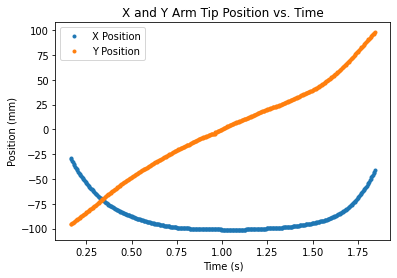

In [5]:
time = origin[:,0].astype(float)/8 # time vector is the same for all parameters
origin_x = origin[:,1].astype(float)
origin_y = origin[:,2].astype(float)

tip_x = tip[:,1].astype(float) - origin_x
tip_y = tip[:,2].astype(float) - origin_y

for index, value in enumerate(tip_y[1:]):
  if tip_y[index+1]-tip_y[index] > 0.5 and time[index] < 1:
    start = index
    break

for index, value in enumerate(tip_y[1:]):
  if tip_y[index+1]-tip_y[index] < 0.1 and time[index] > 1:
    stop = index-10
    break

time = time[start:stop]
tip_x =tip_x[start:stop]
tip_y = tip_y[start:stop]

plt.figure()
plt.title("X and Y Arm Tip Position vs. Time")
plt.plot(time,tip_x,'.',label="X Position")
plt.plot(time,tip_y,'.', label="Y Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (mm)")
plt.legend()

Next, the motor angle is calculated as a function of time based on the x and y position of the tip of the cantilever arm. This angle is measured with respect to the -y axis. The atan2() function is used to allow angles over 90 degrees. This result is plotted over time as well.

Text(0, 0.5, 'Angle (rad)')

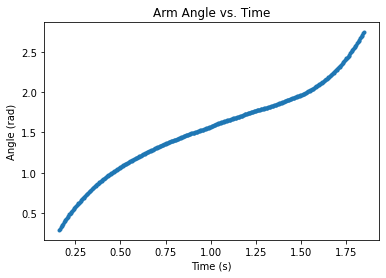

In [6]:
theta = np.arctan2(-tip_x,-tip_y)

plt.figure()
plt.title("Arm Angle vs. Time")
plt.plot(time,theta,'.')
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")

Angular velocity over time is then calculated with numerical differentiation. 

Text(0, 0.5, 'Angular Velocity (rad/s)')

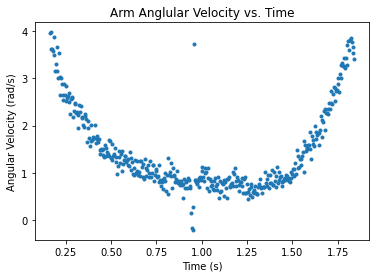

In [7]:
dtheta = np.diff(theta)
dt = np.diff(time)
omega = dtheta/dt

time2 = time[0:-1] # time vector without the final entry, such that it has the same length as the omega vector

plt.figure()
plt.title("Arm Anglular Velocity vs. Time")
plt.plot(time2,omega,'.')
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")

The numerical differentiation introduced a lot of noise, so the results need to be interpolated. A quadratic spline regression will be applied to fit the data, and the two are plotted together.

Text(0, 0.5, 'Angular Velocity (rad/s)')

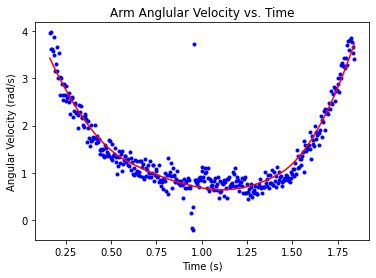

In [8]:
fit = UnivariateSpline(time2,omega,k=2,s=25) # s is a parameter used to tune the fit. Lower s = more overfitting
omega_fit = fit(time2)

plt.figure()
plt.title("Arm Anglular Velocity vs. Time")
plt.plot(time2,omega,'b.')
plt.plot(time2,omega_fit,'r')
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")


Now the torque experienced by the motor must be plotted over time. This can be calculated simply by considering the mass attached via the wire, and the angle of the lever arm at each point in time. For the chosen definition of theta, a weight of mass m and a cantilever arm of length l, the torque about the motor axis is given by the following:

$\tau = m*g*l*sin(\theta)$



Text(0, 0.5, 'Motor Torque (N*m)')

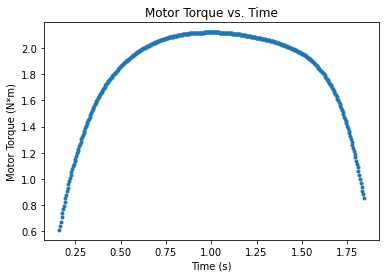

In [9]:
m = 2.162 # mass of the hanging weight, in kg
g = 9.81 # gravitational acceleration, in m/s^2
l = 0.1 # length of the cantilever arm, in mm

tau = m*g*l*np.sin(theta[0:-1]) # disregarding the final value of theta so that the vector has the same length as omega

plt.figure()
plt.title("Motor Torque vs. Time")
plt.plot(time2,tau,'.')
plt.xlabel("Time (s)")
plt.ylabel("Motor Torque (N*m)")

The final torque-speed curve can now be plotted. The curve-fit version of the angular velocity will be used.

Text(0.5, 1.0, 'Torque-Speed Curve')

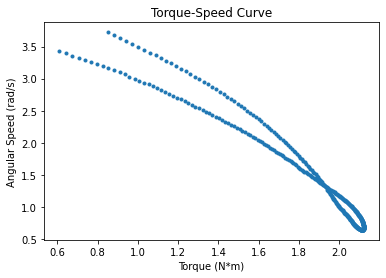

In [10]:
plt.figure()
plt.plot(tau,omega_fit,'.')
plt.xlabel("Torque (N*m)")
plt.ylabel("Angular Speed (rad/s)")
plt.title("Torque-Speed Curve")



This plot appears to loop back on itself because the torque increases and then decreases, while the speed decreases and then increases, and the two processes were not perfectly symmetric due to errors in data collection, numerical differentiation, and curve-fitting. Another spline curve-fit can be applied to this model if the data is arranged in order of increaseing torque first.

Text(0, 0.5, 'Angular Velocity (rad/s)')

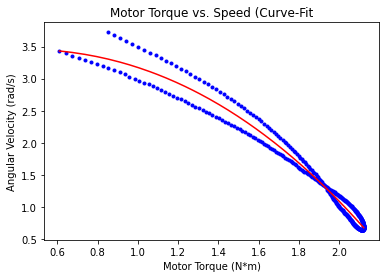

In [11]:
sort_index = np.argsort(tau) # returns the index that would sort tau from low to high
tau = tau[sort_index]
omega_fit = omega_fit[sort_index]

fit2 = UnivariateSpline(tau,omega_fit,k=3,s=10) # s is a parameter used to tune the fit. Lower s = more overfitting
omega_fit2 = fit2(tau)

plt.figure()
plt.title("Motor Torque vs. Speed (Curve-Fit")
plt.plot(tau,omega_fit,'b.')
plt.plot(tau,omega_fit2,'r')
plt.xlabel("Motor Torque (N*m)")
plt.ylabel("Angular Velocity (rad/s)")



The power can then be calculated by multiplying the torque by the angular velocity in order to plot the full torque-speed-power graph.

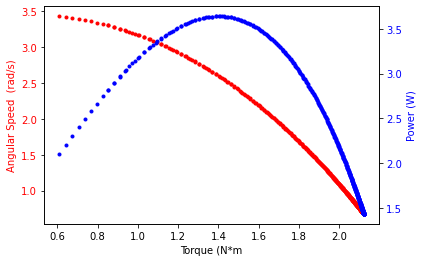

In [12]:
P = tau * omega_fit2
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Torque (N*m') 
ax1.set_ylabel('Angular Speed  (rad/s)', color = 'red') 
ax1.plot(tau, omega_fit2, 'r.') 
ax1.tick_params(axis ='y', labelcolor = 'red') 

ax2 = ax1.twinx() # adds a twin axis
ax2.set_ylabel('Power (W)', color = 'blue') 
ax2.plot(tau, P, 'b.') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 

## Discussion

1. Several things could have been better about the experimental design and setup. A tripod to keep the camera steady would have been beneficial, although most camera movement was (theoretically) accouted for. More uniform motion tracking markers, more accurate marker placement, and a pure white background would have been greatly beneficial in reducing error in the Tracker software. Perhaps most importantly, the method did not account for the dynamic forces induced during the motor's motion. The centripetal forces were likely negligible because the weight was suspended from a long string, but the weight's inertia caused it to sway noticebly, which would cause errors in the theoretical calculation of the torque experienced by the motor because the string tension would not always point straight down. An additional tracker on the string may let that changing angle be calculated and compensated for.

2. The data-fitting model was selected as a polynomial spline because it is a very flexible model. Motor torque-speed curves tend not to have simple mathematical models behind them, but a cubic spline is adaptable enough to construct most arbitraty functions as long as they focus on interpolation rather than extrapolation.

3. Two scipy.interpolate.UnivatiateSpline objects, one quadratic and one cubic, were used to define the model and fit two sets of data. The model is very user-adjustable and the amount of over-fitting can easily be tuned using the "s" parameter, which defines the number of knots in the spline. This model is well-documented in the [SciPy Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html). 

4. The data fits each model fairly well in a qualitative sense, although sharp peaks in the angular velocity data are overly smoothed over. The data fits the torque-vs-speed curve as well as reasonably possible given the errors in data collection causing unexpected asymmetry in the torque loading cycle. In a numerical sense, the models have a high degree of error due to the heavy noise introduced by numerical differentiation. The $r^2$ values of each curve fit are given below.

In [13]:
print(f"The angular velocity vs time fit has an weighted sum of squared residuals of {fit.get_residual():.5f}")
print(f"The angular velocity vs torque fit has an weighted sum of squared residuals of {fit2.get_residual():.5f}")

The angular velocity vs time fit has an weighted sum of squared residuals of 24.99686
The angular velocity vs torque fit has an weighted sum of squared residuals of 6.68722


5. The model is highly limited to within the bounds of the interpolation. The spline model has almost no way to predict the behavior of the function outside the domain of the data points unless the data follows a very simple and obvious relationship, which is not the case here. The high amount of noise and the observed asymmetry in the measurements further prevent this model for being used outside the bounds of the collected data. 